# Advanced Lane Finding

## Importing necessary packages

In [17]:
#importing some useful packages required for this project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Camera Calibration

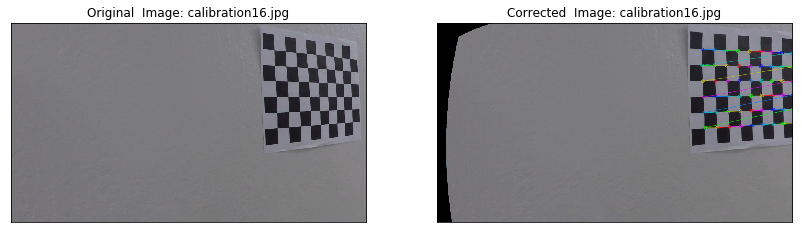

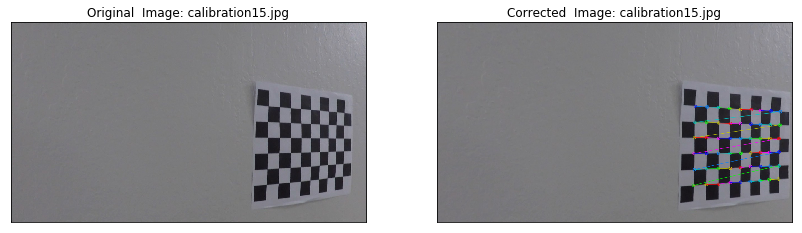

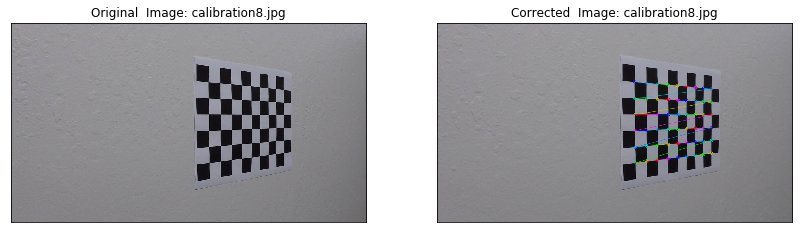

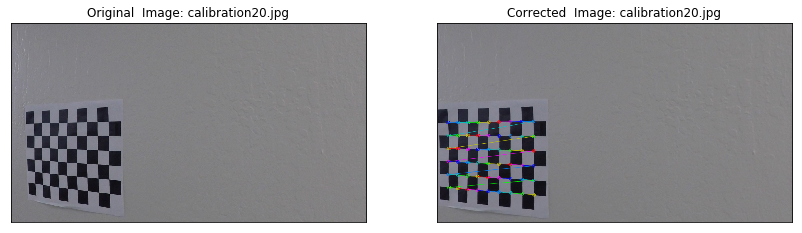

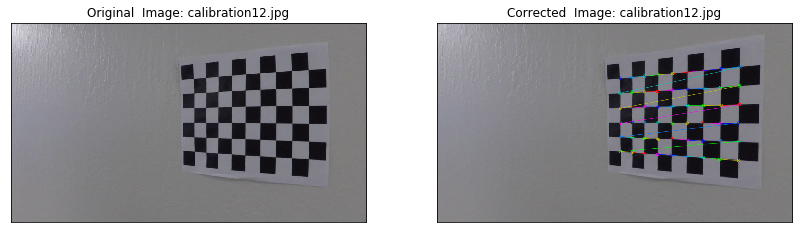

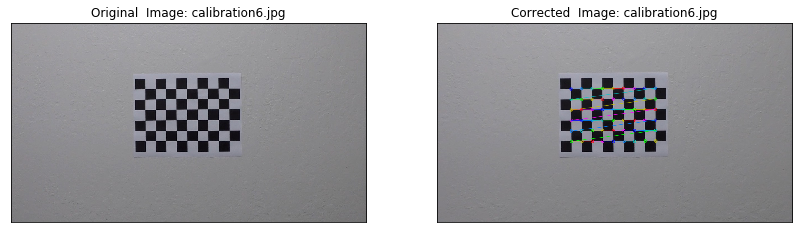

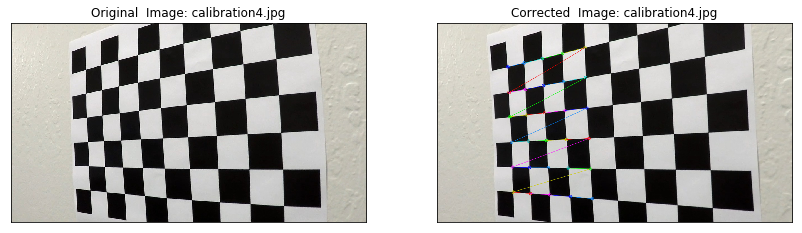

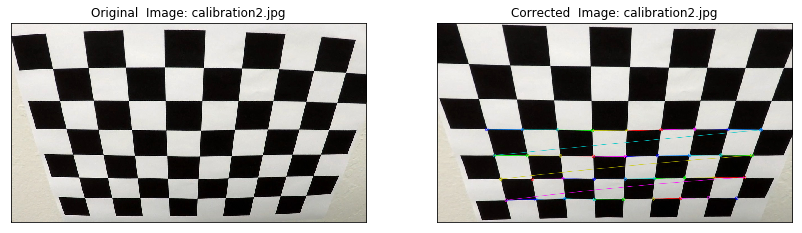

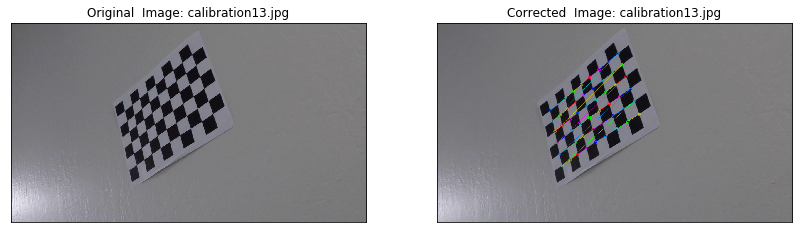

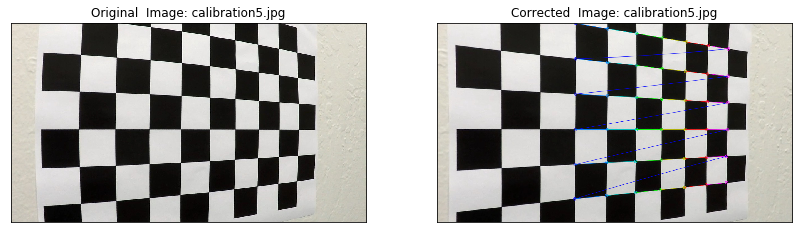

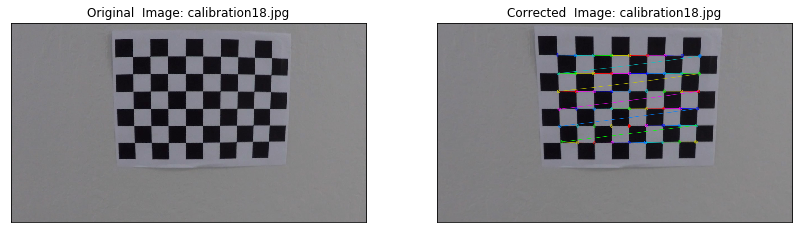

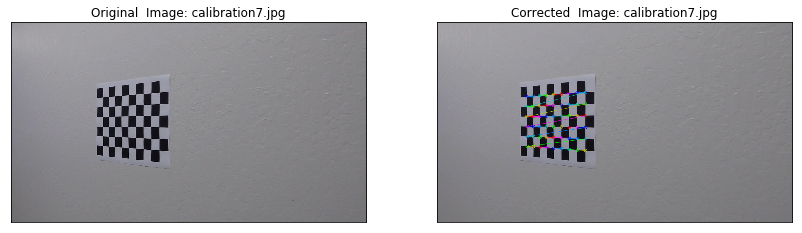

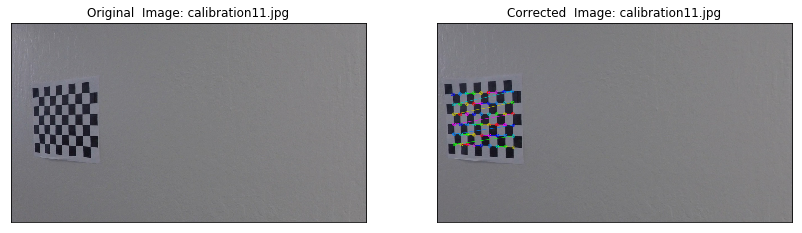

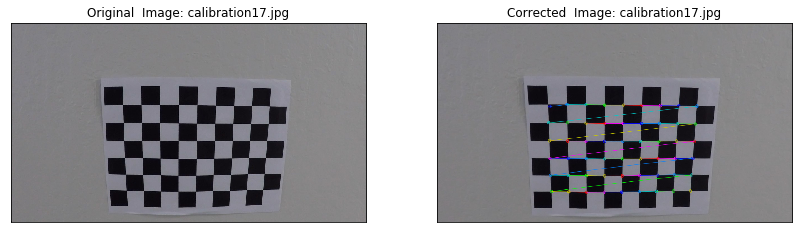

In [18]:
cam_cal_out = 'camera_cal_output'
objpoints = [] # 3d points in real world
imgpoints = [] # 2d points on a plane

# Make object points according to the calibration images
# Found images with the corners: 9x4, 9x5, 9x6 , 8x6, 7x6, 5x6
# 9x4
objpts9x4 = np.zeros((4*9, 3), np.float32)
objpts9x4[:,:2] = np.mgrid[0:9,0:4].T.reshape(-1,2)

# 9x5
objpts9x5 = np.zeros((5*9, 3), np.float32)
objpts9x5[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)

# 9x6
objpts9x6 = np.zeros((6*9, 3), np.float32)
objpts9x6[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# 8x6
objpts8x6 = np.zeros((6*8, 3), np.float32)
objpts8x6[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# 7x6
objpts7x6 = np.zeros((6*7, 3), np.float32)
objpts7x6[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# 5x6
objpts5x6 = np.zeros((6*5, 3), np.float32)
objpts5x6[:,:2] = np.mgrid[0:5,0:6].T.reshape(-1,2)

# Getting the images from the camera_cal directory
img_names = os.listdir('camera_cal/')
for img_name in img_names:
    if img_name.endswith('.jpg'):
        
        #Preparing for subplots of different Processes
        plt.figure(figsize=(14,12))
        
        # Reading the image file using cv2
        img = mpimg.imread('camera_cal/' + img_name)
        
        # Subplot for the original image
        plt.subplot(121)
        plt.title("Original  Image: "+ img_name)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        
        # Making a copy for displaying the processed image later on. We do not want to disrupt the original one
        img_processed = np.copy(img)
        img_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # BGR since the image was read using cv2.imread

        # Checking for the appropriate corners and storing it
        ret, corners = cv2.findChessboardCorners(gray, (9,4), None)
        objpts = objpts9x4
        if not ret:
            ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
            objpts = objpts9x5
        if not ret:
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            objpts = objpts9x6
        if not ret:
            ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
            objpts = objpts8x6
        if not ret:
            ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
            objpts = objpts7x6
        if not ret:
            ret, corners = cv2.findChessboardCorners(gray, (5,6), None)
            objpts = objpts5x6

        # Draw the chessboard corners
        if ret == True:
            cv2.drawChessboardCorners(img_processed,(corners.shape[1],corners.shape[0]), corners, ret)

            # Preparing to calibrate the camera
            objpoints.append(objpts)
            imgpoints.append(corners)

            # Storing the required calibration data in the global variables
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
            img_processed = cv2.undistort(img_processed, mtx, dist, None, mtx)
            
        # Subplot for the processed image
        plt.subplot(122)
        plt.title("Corrected  Image: "+ img_name)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_processed)

        plt.show()
        
        if not os.path.exists(cam_cal_out):
            os.mkdir(cam_cal_out)
        cv2.imwrite(os.path.join(cam_cal_out , img_name), img_processed)
        

## Helper Functions For Test Image Pipeline

### Helper functions for  Reading Image, Conversion to grayscale

In [19]:
# Reading images from the test directory
def read_image(img):
    testImageDir = 'test_images'
    return plt.imread(testImageDir + '/' + img)

# Converting an image to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


### Helper functions for Image undistortion

In [20]:
# Undistorting the image
def undistort_frame(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Helper functions for Binary Threshold

In [21]:
# Applying Sobel Threshold
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Check for orientation and paplly sobel operator accordingly
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # Taking the absolute value    
    abs_sobel = np.absolute(sobel)
    # Calculate the absolute sobel operator
    binary_output = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a binary mask and apply the thresholds to it
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    # Return the mask
    return threshold_mask

# Applying Magnitude Threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = grayscale(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Applying Directional Threshold
def dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the absolute values of gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient and take the absolute value
    direction = np.absolute(np.arctan2(abs_sobel_y,abs_sobel_x))
    # Create a binary mask and apply the thresholds to it
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # Return the mask
    return mask


# Combining all the thresholds to produce a binary warped image
def combined_threshold(img):
    # Converting image to grayscale
    gray = grayscale(img)
    # Taking the width and height of the grayscale image
    height, width = gray.shape
    # Applying gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    # Applying gradient direction threshold
    dir_binary = dir_thresh(gray, thresh=(np.pi/6, np.pi/2))
    # Applying gradient magnitude threshold
#     mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 250)) #3, 30, 100
    # Combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # L and S threshold for more precision on varying conditions
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    # L channel discards pixels which appear darker under shadows
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1

    # Return the result
    return color_combined


### Helper Function for Perspective Transformation

In [22]:
def perspective_transform(img):
    # Define 4 source and 4 destination points = np.float32([[,],[,],[,],[,]])
    src = np.float32([[568, 468.5], [715, 468.5], [1041.5, 679.1], [269.5, 679.1]])
    dest = np.float32([[400, 0], [880, 0], [880, 710], [400, 710]])
    #Calculate Perspective Transform
    M = cv2.getPerspectiveTransform(src, dest)
    #Calculate inverse Perspective Transform
    Minv = cv2.getPerspectiveTransform(dest, src)
    # Warp the perspective Transform into the image
    warped_img = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    # Return the results
    return warped_img, M, Minv

### Helper functions for Fitting Polynomial

In [23]:
def find_lane_pixels(binary_warped):
    # Take a histogram along all the columns in the lower half of the image.
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
    # Find x-positions of the base of the lanes using the two most prominent peaks in the histogram.
    mid = np.int(len(histogram)//2)
    left_win_center = np.argmax(histogram[0:mid])
    right_win_center = np.argmax(histogram[mid:]) + mid
    # Use a sliding window to find and follow the lines up to the top of the frame
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Define some variables to store the lane pixels
    margin = 100
    nonzero = binary_warped.nonzero()
    min_nonzero_pixel_count = 200
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    h = binary_warped.shape[0]
    left_windows = []
    right_windows = []
    for i in range(nwindows):
        # Create two rectangular windows, calculate from the image center and margin and store them
        win_top = h - (i + 1) * window_height
        win_bottom = win_top + window_height
        left_win_left = left_win_center - margin
        left_win_right = left_win_center + margin
        right_win_left = right_win_center - margin
        right_win_right = right_win_center + margin
        left_windows.append(((left_win_left, win_bottom), (left_win_right, win_top)))
        right_windows.append(((right_win_left, win_bottom), (right_win_right, win_top)))
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                     & (nonzerox >= left_win_left) & (nonzerox < left_win_right)).nonzero()[0]
        right_inds = ((nonzeroy >= win_top) & (nonzeroy < win_bottom)\
                      & (nonzerox >= right_win_left) & (nonzerox < right_win_right)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        # Move the center of windows
        if len(left_inds) > min_nonzero_pixel_count:
            left_win_center = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > min_nonzero_pixel_count:
            right_win_center = np.int(np.mean(nonzerox[right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, left_windows, right_windows
    
# Getting the averagle of all the lane pixels    
def find_lane(binary_warped):
    # Get the pixels
    leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(binary_warped)
    # For left lane
    if (len(leftx) == 0):
        left_fit = None
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    # For right lane
    if (len(rightx) == 0):
        right_fit = None
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    # Return the values
    return left_fit, right_fit

# Fit the polynomial into the line
def get_fit_lines(warped, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

# Use the line from the previous frame for faster sliding window search
def find_lane_fast(binary_warped, previuos_left_fit, previous_right_fit):
    # Make a nonsero array
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (previuos_left_fit[0]*(nonzeroy**2) + previuos_left_fit[1]*nonzeroy + previuos_left_fit[2] - margin)) & 
                      (nonzerox < (previuos_left_fit[0]*(nonzeroy**2) + previuos_left_fit[1]*nonzeroy + previuos_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] - margin)) & 
                       (nonzerox < (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


### Calculating Radius of Curvature

In [24]:
# Implement readius of curvature function
def calculate_curvature(fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    x_m_per_pix = 3.7/480 # meters per pixel in y dimension
    y_m_per_pix = 10/130.0 # meters per pixel in x dimension
    # Multiply it with the x and y values in fitted line
    fitx_m = fitx * x_m_per_pix
    ploty_m = ploty * y_m_per_pix
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty_m)
    fit = np.polyfit(ploty_m, fitx_m, 2)
    # Calculation of R_curve (radius of curvature)
    curverad = ((1 + (2 * fit[0] * y_eval + fit[1])**2)**1.5) / np.absolute(2 * fit[0])
    # Return the result
    return curverad

# Calculate the curvature for left and right lanes and return the average
def calculate_average_curvature(binary_warped, left_fit, right_fit):
    leftx, rightx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    left_radius = calculate_curvature(leftx, ploty)
    right_radius = calculate_curvature(rightx, ploty)
    return (left_radius + right_radius) / 2


### Calculating Distance from center

In [25]:
# Calcuating some values based on distance
def get_lane_values(left_fitx, right_fitx, ploty):
    # meters per pixel in y dimension
    x_m_per_pix = 3.7/480
    # Mean distance
    mean_distance = np.mean(right_fitx - left_fitx) * x_m_per_pix
    # Calculate the center
    lane_center = (left_fitx[-1] + right_fitx[-1]) // 2
    # Car center, Assuming the camera is mounted in the middle
    car_center = 1280/2
    # Calculate center offset
    center_offset = (lane_center - car_center) * x_m_per_pix
    # Return the values
    return mean_distance, center_offset

# Checking the lane values
def lane_accuracy(binary_warped, left_fit, right_fit):
    #Getting lane values
    left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)    
    # Checking distance
    mean_distance, center_offset = get_lane_values(left_fitx, right_fitx, ploty)
    if mean_distance < 2.5 or mean_distance > 5:
        return False
    if center_offset > 2:
        return False
    # Checking radius
    left_radius = calculate_curvature(left_fitx, ploty)
    right_radius = calculate_curvature(right_fitx, ploty)
    radius = (left_radius + right_radius)/2
    if radius < 30:
        return False
    if radius < 10000 and (left_fit[0] * right_fit[0]) < 0:
        return False
    # Default value
    return True

### Drawing Line and Text

In [26]:
# Interpolating the lane lines in the image
def draw_lane(undist, binary_warped, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Get the lane lines
    left_fitx, right_fitx, ploty = get_fit_lines(binary_warped, left_fit, right_fit)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# Add text and interpolate them to the image
def draw_text(img, radius, center_offset):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Lane radius of curvature: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_offset > 0:
        direction = 'right'
    elif center_offset < 0:
        direction = 'left'
    abs_center_offset = abs(center_offset)
    text = 'Vehicle is {:04.3f}'.format(abs_center_offset) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return img


## Reading the test Images from the directory

In [27]:
image_files = os.listdir('test_images')

## Pipeline for Test Images

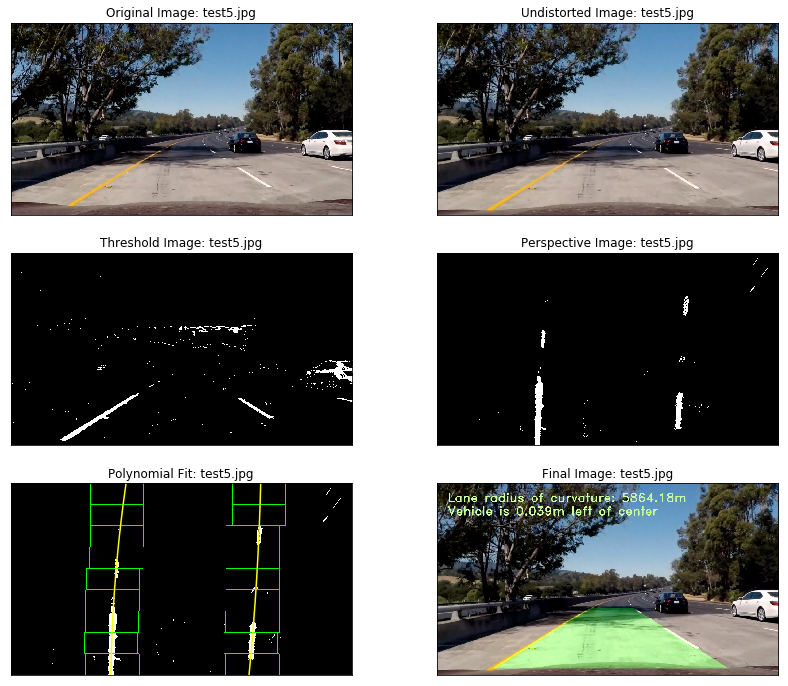

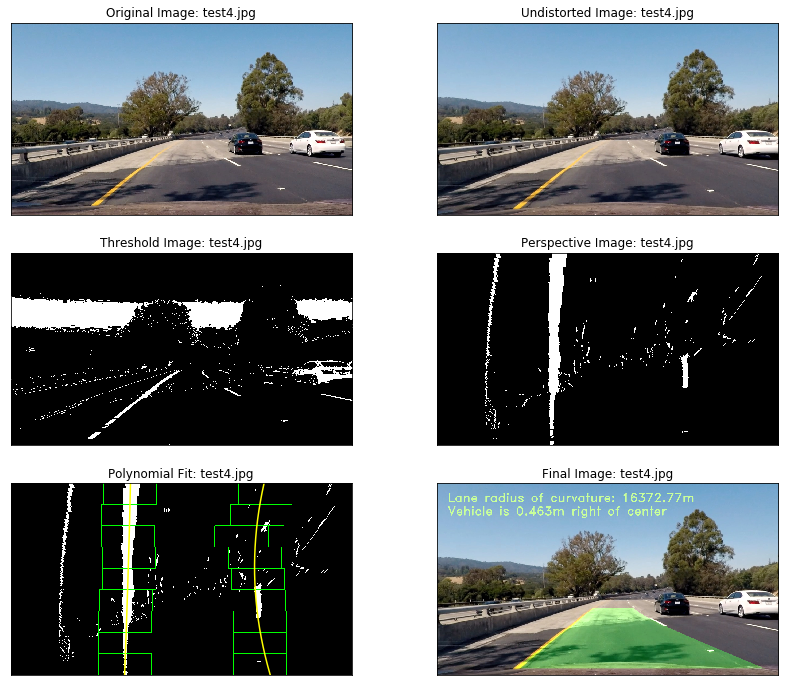

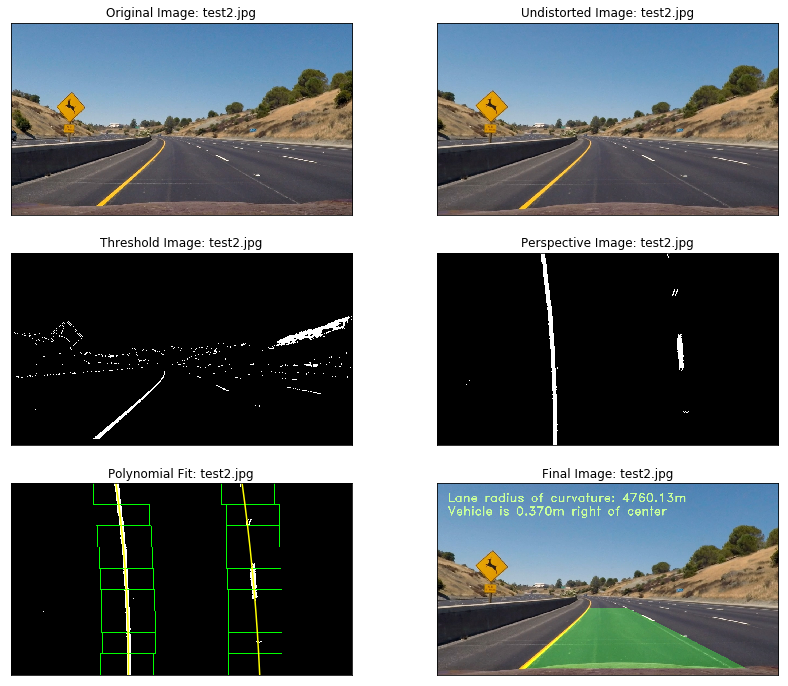

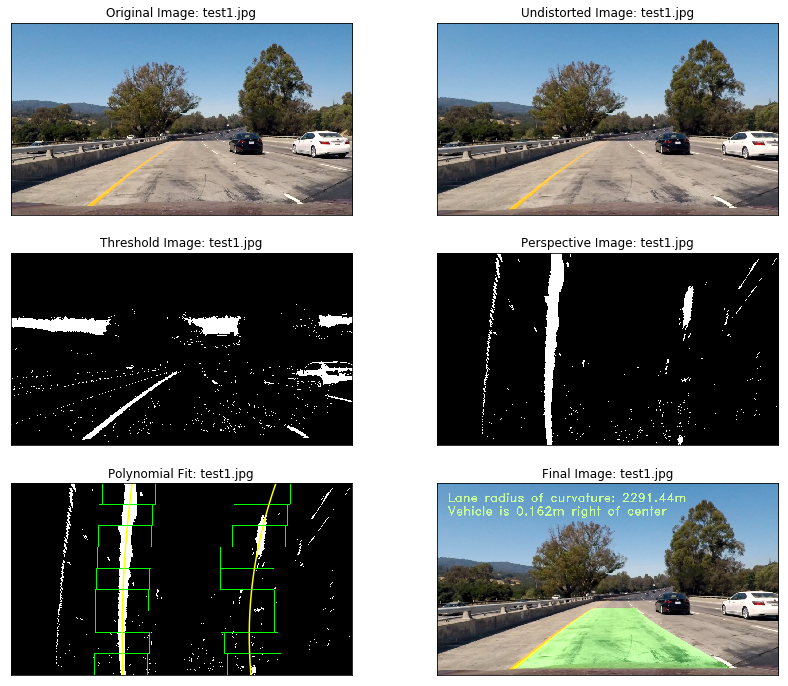

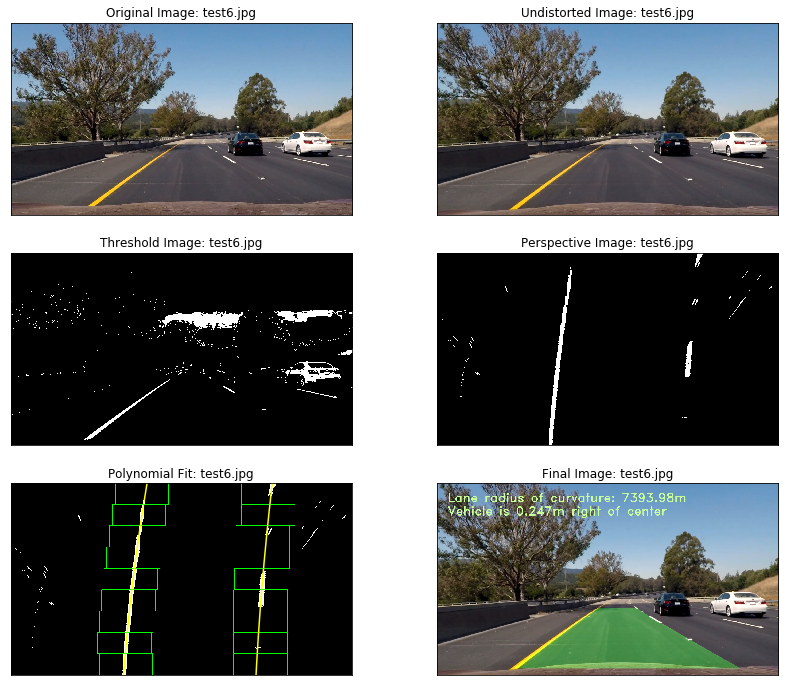

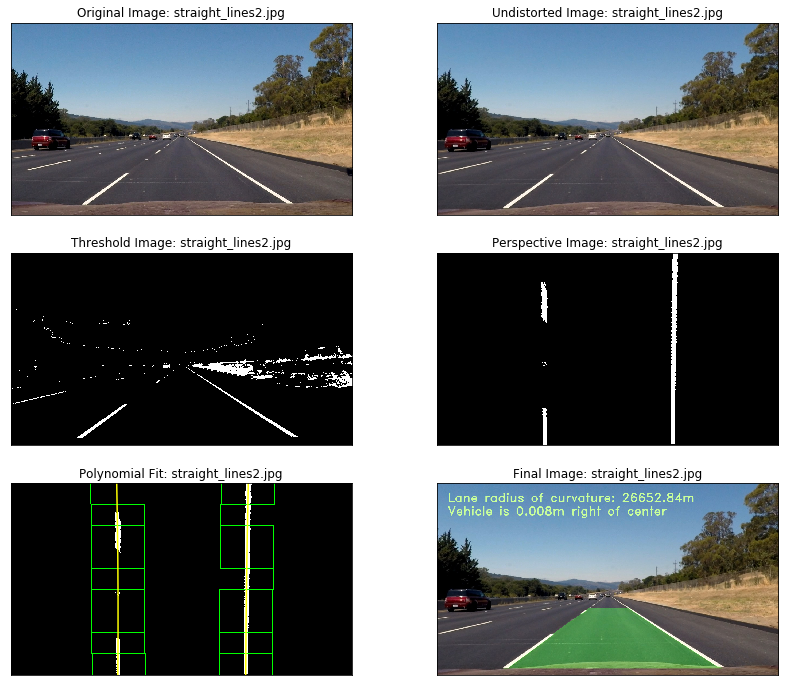

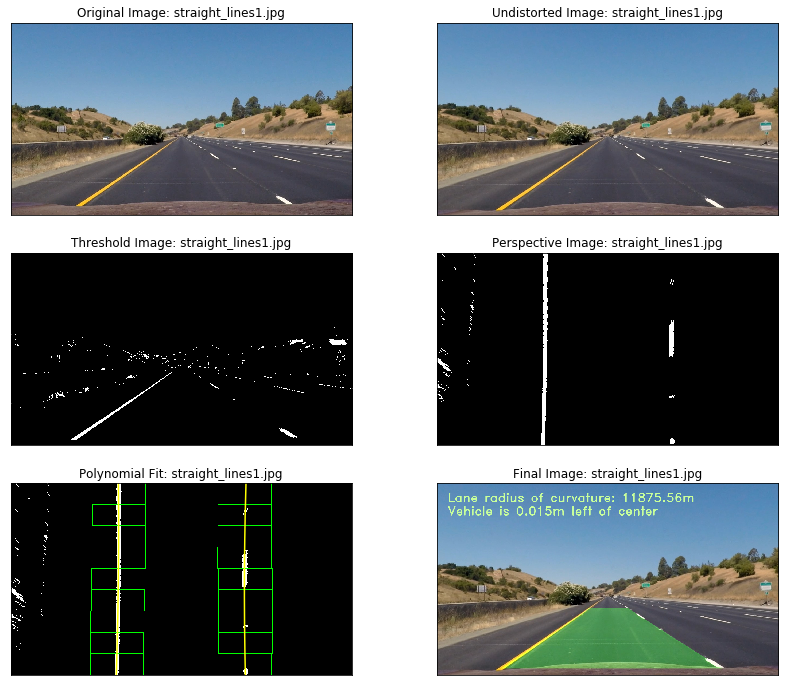

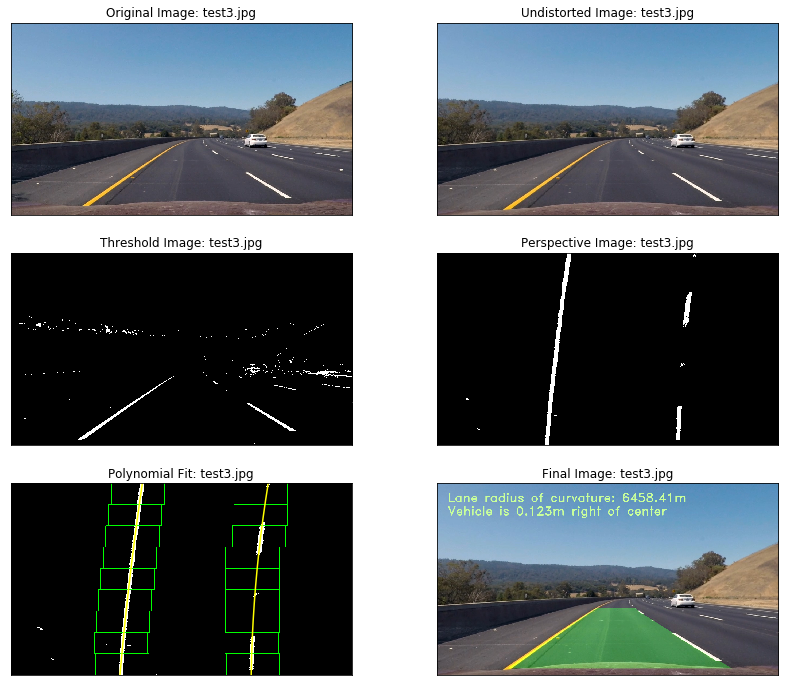

In [28]:
# For storing the undistorted test images
dist_ouput_dir = 'output_images/distortion_corrected'
# For storing the binary threshold result on test images
thresh_ouput_dir = 'output_images/binary_image'
# For storing transformation result on test images
perspective_ouput_dir = 'output_images/perspective_transformed'
# For storing polyfit on test images
polynomial_ouput_dir = 'output_images/polynomial_fit' 
# For storing the processed images
final_ouput_dir = 'output_images/final_image' 

for image_file in image_files:
    if image_file.endswith('.jpg'):
        image = read_image(image_file)
        
        #Preparing for subplots of different Processes
        plt.figure(figsize=(14,12))
        
        plt.subplot(321)
        plt.title("Original Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)
        
        # Undistort test images
        undistort_img = undistort_frame(image)
        plt.subplot(322)
        plt.title("Undistorted Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(undistort_img)
        if not os.path.exists(dist_ouput_dir):
            os.mkdir(dist_ouput_dir)
        cv2.imwrite(os.path.join(dist_ouput_dir , image_file), undistort_img)
        
        # Add threshold mask
        binary_image = combined_threshold(undistort_img)
        plt.subplot(323)
        plt.title("Threshold Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(binary_image, cmap='gray')
        if not os.path.exists(thresh_ouput_dir):
            os.mkdir(thresh_ouput_dir)
        cv2.imwrite(os.path.join(thresh_ouput_dir , image_file), binary_image)
        
        # Apply perspective transform
        perspective_img, M, Minv = perspective_transform(binary_image)
        plt.subplot(324)
        plt.title("Perspective Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(perspective_img, cmap='gray')
        if not os.path.exists(perspective_ouput_dir):
            os.mkdir(perspective_ouput_dir)
        cv2.imwrite(os.path.join(perspective_ouput_dir , image_file), perspective_img)
        
        # Calculate lane pixels
        leftx, lefty, rightx, righty, left_windows, right_windows = find_lane_pixels(perspective_img)
        left_fit, right_fit = find_lane(perspective_img)
        left_fitx, right_fitx, ploty = get_fit_lines(perspective_img, left_fit, right_fit)
        polynomial_image = np.dstack((perspective_img, perspective_img, perspective_img))*255
        for win in left_windows:
            cv2.rectangle(polynomial_image, win[0], win[1], (0, 255, 0), 2)
        for win in right_windows:
            cv2.rectangle(polynomial_image, win[0], win[1], (0, 255, 0), 2)
            
        plt.subplot(325)
        plt.title("Polynomial Fit: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(polynomial_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, perspective_img.shape[1])
        plt.ylim(perspective_img.shape[0], 0)
        
        if not os.path.exists(polynomial_ouput_dir):
            os.mkdir(polynomial_ouput_dir)
        cv2.imwrite(os.path.join(polynomial_ouput_dir , image_file), polynomial_image)
        
        # Calculate lane pixels and draw lanes on the final image
        left_fit, right_fit = find_lane(perspective_img)
        leftx, rightx, ploty = get_fit_lines(perspective_img, left_fit, right_fit)
        final_img = draw_lane(undistort_img, perspective_img, left_fit, right_fit, Minv)
        mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
        radius = calculate_average_curvature(perspective_img, left_fit, right_fit)
        final_img = draw_text(final_img, radius, center_offset)
        
        plt.subplot(326)
        plt.title("Final Image: "+ image_file)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(final_img)
        
        if not os.path.exists(final_ouput_dir):
            os.mkdir(final_ouput_dir)
        cv2.imwrite(os.path.join(final_ouput_dir , image_file), final_img)
        
        plt.show()
        
        # New line for a new image
        print("")


## Pipeline for Video Processing

In [29]:
# Global variables to store the line information
left_best_fit = None
right_best_fit = None

#Processing pipeline
def process_frame(img):
    # 1) Distortion correction
    undistorted = undistort_frame(img)
    # 2) Threshold mask
    masked = combined_threshold(undistorted)
    # 3) Perspective Transform
    binary_warped, M, Minv = perspective_transform(masked)
    # 4) Detecting Lines
    global left_best_fit
    global right_best_fit
    left_fit = None
    right_fit = None
    # 4.1) Check to see if any lane was detected in previous frame, 
    # if no we use sliding window, else search from prior
    if left_best_fit == None or right_best_fit == None:
        left_fit, right_fit = find_lane(binary_warped)
    else:
        left_fit, right_fit = find_lane_fast(binary_warped, left_best_fit, right_best_fit)
        if left_fit is not None and right_fit is not None:
            if not lane_accuracy(binary_warped, left_fit, right_fit):
                left_fit, right_fit = find_lane(binary_warped)
    # 4.2) Add the values to the best fit array
    left_best_fit = left_fit
    right_best_fit = right_fit
    # 4.3) Get the fitted lines
    if left_best_fit is not None and right_best_fit is not None:
        leftx, rightx, ploty = get_fit_lines(binary_warped, left_best_fit, right_best_fit)
        # 4.4) Getting the curvature and distance from center
        mean_distance, center_offset = get_lane_values(leftx, rightx, ploty)
        # 4.5) Getting the final radius
        radius = calculate_average_curvature(binary_warped, left_best_fit, right_best_fit)
        # 4.6) Draw the line
        result = draw_lane(img, binary_warped, left_best_fit, right_best_fit, Minv)
        # 4.7) Draw the text
        result = draw_text(result, radius, center_offset)
        # Return the processed frame
        return result
    else:
        return img

## Import Video Package for loading test Videos

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Applying pipeline on project video

In [31]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:55<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 8s, sys: 36.5 s, total: 4min 44s
Wall time: 6min 58s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))